# Stochastic Optimization

## Exercise on Control

Thomas Dos et Lisa Escaron


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

Today you'll explore advanced SGD methods (momentum, Adam) and compare them with gradient-free approaches on a robotic arm control problem. You'll also learn automatic differentiation with JAX.

In [2]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import jax
import jax.numpy as jnp
from jax import grad, jit
from typing import Tuple, List, Callable
import time

# Set random seeds for reproducibility
np.random.seed(42)

# Enable JAX to run on CPU (for consistent behavior across platforms)
jax.config.update('jax_platform_name', 'cpu')

print("Setup complete! JAX version:", jax.__version__)
print("NumPy version:", np.__version__)

Setup complete! JAX version: 0.8.0
NumPy version: 2.0.1


# Exploring the Robot Arm
Run the provided visualization to understand the 2-joint planar arm. Experiment with different joint angles. We will experiment with two different libraries for this robot arm: numpy and [jax](docs.jax.dev/en/latest/index.html). Jax will enable easier gradient calculations through [automatic differentiation](https://huggingface.co/blog/andmholm/what-is-automatic-differentiation). For now, understand and explore this 2-joint robot arm which uses two angles to calculate the end position of the arm.

In [3]:
def forward_kinematics_numpy(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm.
    
    Parameters:
    -----------
    theta : np.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : np.ndarray, shape (2,)
        Link lengths [L1, L2]
    
    Returns:
    --------
    position : np.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # First joint position
    x1 = L1 * np.cos(theta1)
    y1 = L1 * np.sin(theta1)
    
    # End-effector position
    x2 = x1 + L2 * np.cos(theta1 + theta2)
    y2 = y1 + L2 * np.sin(theta1 + theta2)
    
    return np.array([x2, y2])

In [4]:
# JAX version (for automatic differentiation)
def forward_kinematics_jax(theta: jnp.ndarray, lengths: jnp.ndarray) -> jnp.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm (JAX version).
    
    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : jnp.ndarray, shape (2,)
        Link lengths [L1, L2]
    
    Returns:
    --------
    position : jnp.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # First joint position
    x1 = L1 * jnp.cos(theta1)
    y1 = L1 * jnp.sin(theta1)
    
    # End-effector position
    x2 = x1 + L2 * jnp.cos(theta1 + theta2)
    y2 = y1 + L2 * jnp.sin(theta1 + theta2)
    
    return jnp.array([x2, y2])

In [5]:
# Get all joint positions for visualization
def get_arm_points(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Get positions of all joints for visualization.
    
    Returns:
    --------
    points : np.ndarray, shape (3, 2)
        Positions of [base, joint1, end-effector]
    """
    theta1, theta2 = theta
    L1, L2 = lengths
    
    # Base at origin
    p0 = np.array([0.0, 0.0])
    
    # First joint
    p1 = np.array([L1 * np.cos(theta1), L1 * np.sin(theta1)])
    
    # End-effector
    p2 = p1 + np.array([L2 * np.cos(theta1 + theta2), 
                        L2 * np.sin(theta1 + theta2)])
    
    return np.array([p0, p1, p2])

In [6]:
# Test the implementations
print("Testing forward kinematics...")
test_theta = np.array([np.pi/4, np.pi/4])
test_lengths = np.array([1.0, 1.0])

pos_numpy = forward_kinematics_numpy(test_theta, test_lengths)
pos_jax = forward_kinematics_jax(test_theta, test_lengths)

print(f"NumPy result: {pos_numpy}")
print(f"JAX result: {pos_jax}")
print(f"Match: {np.allclose(pos_numpy, np.array(pos_jax))}")

Testing forward kinematics...
NumPy result: [0.70710678 1.70710678]
JAX result: [0.7071067 1.7071068]
Match: True


In [7]:
# Visualization Utilities
def plot_arm(theta: np.ndarray, lengths: np.ndarray, 
             target: np.ndarray = None, obstacles: List = None,
             ax=None, title: str = "Robot Arm"):
    """
    Plot the robot arm configuration.
    
    Parameters:
    -----------
    theta : np.ndarray
        Joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position to visualize
    obstacles : List of tuples, optional
        List of (x, y, radius) for circular obstacles
    ax : matplotlib axis, optional
        Axis to plot on
    title : str
        Plot title
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Get arm points
    points = get_arm_points(theta, lengths)
    
    # Plot arm links
    ax.plot(points[:, 0], points[:, 1], 'o-', linewidth=3, 
            markersize=8, label='Arm', color='blue')
    
    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')
    
    # Plot end-effector
    ax.plot(points[-1, 0], points[-1, 1], 'ro', 
            markersize=10, label='End-effector')
    
    # Plot target if provided
    if target is not None:
        ax.plot(target[0], target[1], 'g*', 
                markersize=15, label='Target')
    
    # Plot obstacles if provided
    if obstacles is not None:
        for obs in obstacles:
            circle = Circle((obs[0], obs[1]), obs[2], 
                          color='red', alpha=0.3, label='Obstacle')
            ax.add_patch(circle)
    
    # Set axis properties
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    
    return ax

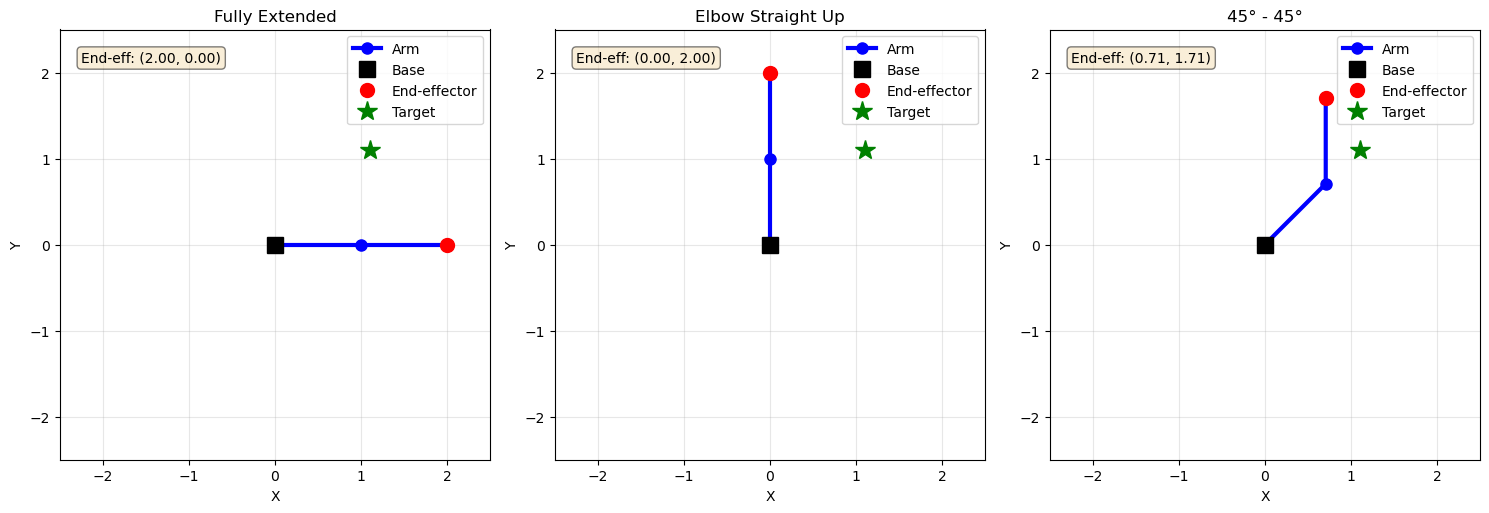

In [8]:
# Standard link lengths we'll use throughout
LENGTHS = np.array([1.0, 1.0])

# Example: Visualize different arm configurations
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.flatten()

# TODO: try more configurations
example_configs = [
    (np.array([0.0, 0.0]), "Fully Extended"),
    (np.array([np.pi/2, 0.0]), "Elbow Straight Up"),
    (np.array([np.pi/4, np.pi/4]), "45° - 45°"),
]

target = np.array([1.1, 1.1])
for i, (theta, title) in enumerate(example_configs):
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=title)
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

<div class="alert alert-info">
Q1: The robot arm has multiple solutions to reach the same point (elbow-up vs elbow-down configurations). Using the provided forward_kinematics function, find two different joint angle configurations θ = [θ₁, θ₂] that place the end-effector at approximately (1.1, 1.1). What does this tell you about the optimization landscape?
</div>

theta: [0.10578748 1.35922137]  => end: [1.1 1.1]
theta: [ 1.46500885 -1.35922137]  => end: [1.1 1.1]


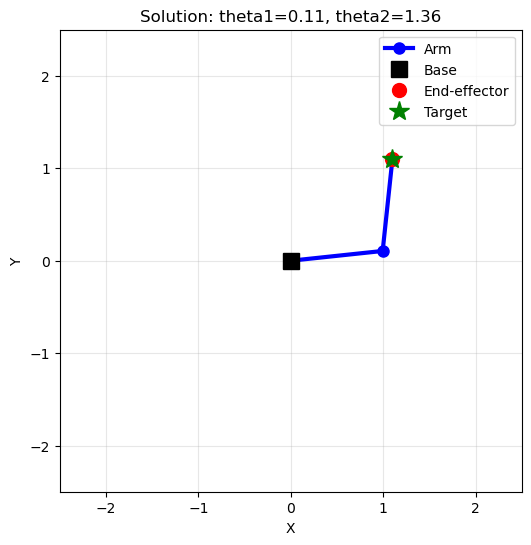

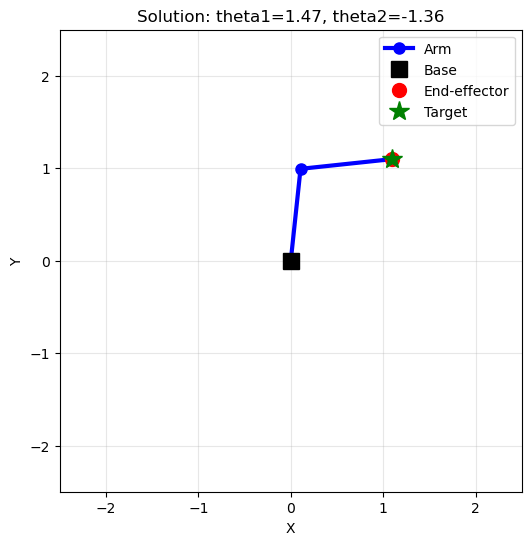

In [ ]:
## Q1 solution and answer here

""" 
On sait qu'un a deux solutions : une avec le coude vers le sol et une avec le coude vers le haut.
On pourra calculer la deuxième solution à partir de la première trouvé en prenant juste l'angle négatif de theta2.

On utilise la loi des cosinus pour calculer nos angles
"""

# position cible
x, y = 1.1, 1.1
goal = np.array([x, y])

#longueurs utilisés
L1, L2  = LENGTHS

r_2 = x**2 + y**2
r = np.sqrt(r_2)

# cos(theta2) et les deux solutions pour theta2
cos_th2 = (r_2 - L1**2 - L2**2) / (2 * L1 * L2)
cos_th2 = np.clip(cos_th2, -1.0, 1.0)
th2_a = np.arccos(cos_th2)   # solution 1 (elbow-down)
th2_b = -th2_a               # solution 2 (elbow-up)

# calcul de theta1 correspondant
def compute_theta1(th2):
    k1 = L1 + L2 * np.cos(th2)
    k2 = L2 * np.sin(th2)
    return np.arctan2(y, x) - np.arctan2(k2, k1)

th1_a = compute_theta1(th2_a)
th1_b = compute_theta1(th2_b)

# normaliser angles dans [-pi, pi]
def wrap(a): return (a + np.pi) % (2*np.pi) - np.pi
sols = np.array([[wrap(th1_a), wrap(th2_a)],
                 [wrap(th1_b), wrap(th2_b)]])

for s in sols:
    print("theta:", s, " => end:", forward_kinematics_numpy(s, LENGTHS))
    plot_arm(s, LENGTHS, target=goal, title=f"Solution: theta1={s[0]:.2f}, theta2={s[1]:.2f}")




Il y a deux configurations principales pour atteindre le point (1.1, 1.1) avec un bras de longueur 1 pour chaque segment. Ains, en utilisant un processus d'optimisation, il faudra être conscient de la possibilité d'avoir plusieurs minima locaux correspondant à différentes configurations du bras.

## Part 1: Automatic Differentiation

Instead of guessing at the angles for a target, we will calculate them exactly. Use the provided JAX implementation to compute gradients of the loss function with respect to joint angles.

In [29]:
# Loss Functions
def loss_target_reaching(theta: jnp.ndarray, lengths: jnp.ndarray, 
                        target: jnp.ndarray) -> float:
    """
    Loss for reaching a target position.
    
    L = ||end_effector(theta) - target||^2
    
    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position
    
    Returns:
    --------
    loss : float
        Squared distance to target
    """
    end_effector = forward_kinematics_jax(theta, lengths)
    return jnp.sum((end_effector - target) ** 2)

In [10]:
# Create JIT-compiled versions for speed
loss_target_reaching_jit = jit(loss_target_reaching)
print(loss_target_reaching)
print(loss_target_reaching_jit)

<function loss_target_reaching at 0x7f3c7039b600>
<PjitFunction of <function loss_target_reaching at 0x7f3c7039b600>>


In [11]:
# Create gradient functions
grad_loss_target = jit(grad(loss_target_reaching, argnums=0))

In [12]:
# Test the loss functions
print("Testing loss functions...")
test_theta = jnp.array([0.5, 0.5])
test_lengths = jnp.array([1.0, 1.0])
test_target = jnp.array([1.0, 1.0])

loss_val = loss_target_reaching(test_theta, test_lengths, test_target)
print(f"Loss value: {loss_val:.4f}")

grad_val = grad_loss_target(test_theta, test_lengths, test_target)
print(f"Gradient: {grad_val}")

Testing loss functions...
Loss value: 0.2776
Gradient: [-0.19397666 -0.35651368]


<div class="alert alert-info">
Q2: Compute the gradient using JAX autodiff at $θ=[π/6, π/4]$
Then verify it matches a manual finite-difference approximation:

For finite differences, use:
  $∂L/∂θᵢ ≈ (L(θ + h*eᵢ) - L(θ - h*eᵢ)) / (2h)$
  where $eᵢ$ is the i-th unit vector and $h = 1e-5$
</div>

In [39]:
theta = jnp.array([jnp.pi/6, jnp.pi/4])

# Gradient
grad_val = grad_loss_target(theta, LENGTHS, goal)
print(f"Gradient at theta=[π/6, π/4]: {grad_val}")

# Finite difference approximation à la main
h = 1e-5
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])

fd_approx = jnp.array([
    (loss_target_reaching(theta + h * e1, LENGTHS, goal) - 
     loss_target_reaching(theta - h * e1, LENGTHS, goal)) / (2 * h),
    (loss_target_reaching(theta + h * e2, LENGTHS, goal) - 
     loss_target_reaching(theta - h * e2, LENGTHS, goal)) / (2 * h)
])
print(f"Finite difference approximation: {fd_approx}")


Gradient at theta=[π/6, π/4]: [0.7503791  0.14142144]
Finite difference approximation: [0.75250864 0.13932586]


On a bien un résultat assez proche avec les deux méthodes, ce qui valide l'utilisation de l'autodifférence.

<div class="alert alert-info">
Q3: Compare the computational time of evaluating the gradient using JAX autodiff versus evaluating just the forward pass (loss calculation only). Run each 1000 times and report the ratio. What does this tell you about the computational overhead of automatic differentiation?</div>

In [46]:
start_time = time.time()
for i in range(1000):
    grad_val = grad_loss_target(theta, LENGTHS, goal)
end_time = time.time()

grad_time = end_time - start_time
print(f"Time for 1000 gradient computations: {grad_time:.4f} seconds")



Time for 1000 gradient computations: 0.1349 seconds


In [44]:
start_time = time.time()
for i in range(1000):
    h = 1e-5
    e1 = jnp.array([1.0, 0.0])
    e2 = jnp.array([0.0, 1.0])

    fd_approx = jnp.array([
        (loss_target_reaching(theta + h * e1, LENGTHS, goal) - 
        loss_target_reaching(theta - h * e1, LENGTHS, goal)) / (2 * h),
        (loss_target_reaching(theta + h * e2, LENGTHS, goal) - 
        loss_target_reaching(theta - h * e2, LENGTHS, goal)) / (2 * h)
    ])
end_time = time.time()

grad_time = end_time - start_time
print(f"Time for 1000 forward pass: {grad_time:.4f} seconds")



Time for 1000 forward pass: 8.0455 seconds


JAX est significativement plus rapide que le calcul par différences finies. Le ratio dépend de la complexité du modèle, mais en général, l'autodifférence est beaucoup plus efficace pour des modèles complexes.

## Part 2: Gradient Descent

Gradient Descent (GD) is the foundational optimization algorithm that iteratively moves parameters in the direction of steepest descent:
$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$

While conceptually simple, GD can be sensitive to the learning rate $η$ and may struggle with saddle points or narrow valleys in the loss landscape where the gradient direction changes rapidly.

For this exercise, implement basic gradient descent to move the robot arm to a target position.

In [48]:
def gradient_descent(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    
    # Optimization loop
    for i in range(n_iterations):
        # TODO: Compute gradient
        gradient = grad_fn(theta, lengths_jax, target_jax)
        
        # TODO: Update theta using gradient descent rule
        theta = theta - learning_rate * gradient
        
        # Store history
        theta_history[i + 1] = np.array(theta)        
        loss_history[i + 1] = float(loss_fn(theta))        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
    
    return theta_history, loss_history, ee_trajectory

<div class="alert alert-info">
Q4: Run GD with learning rates $η = [0.001, 0.01, 0.1, 0.5, 1.0]$ for 500 iterations each, starting from $θ₀ = [0.1, 0.1]$ targeting (0.5, 1.5). Plot the loss curves. At what learning rate do you observe divergence? Explain what's happening in terms of the gradient descent update rule.
</div>

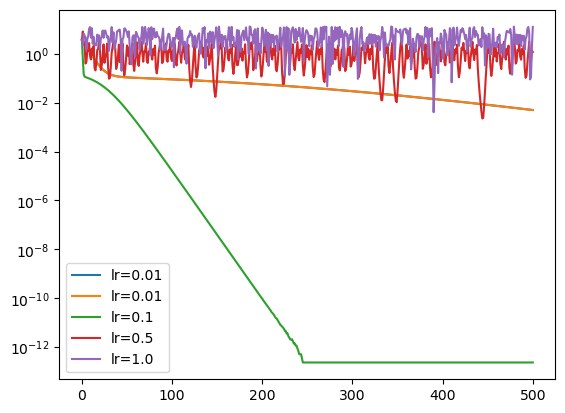

In [54]:
learning_rates = [0.01, 0.01, 0.1, 0.5, 1.0]
n_iterations = 500
theta_init = np.array([0.1, 0.1])
goal = np.array([0.5, 1.5])

for lr in learning_rates:
    theta_hist, loss_hist, ee_traj = gradient_descent(
        theta_init, goal, LENGTHS, learning_rate=lr, n_iterations=n_iterations)
    plt.plot(loss_hist, label=f"lr={lr}") 
plt.yscale('log')
plt.legend()
plt.show()

On a divergence pour un taux d'apprentissage supérieur à 0.1. En effet, avec un taux d'apprentissage trop élevé, les mises à jour des paramètres deviennent trop grandes, ce qui peut entraîner des oscillations autour du minimum ou même un éloignement du minimum, au lieu de converger vers celui-ci. Le taux idéal est 0.1. Pour des valeurs inférieures, la convergence est plus lente. 

<div class="alert alert-info">
Q5: For $η = 0.01$, plot the end-effector trajectory in 2D space (not the loss, but the actual path the end-effector takes). Does it take the most direct path to the target? Why or why not? (Hint: think about parameter space vs task space)
</div>

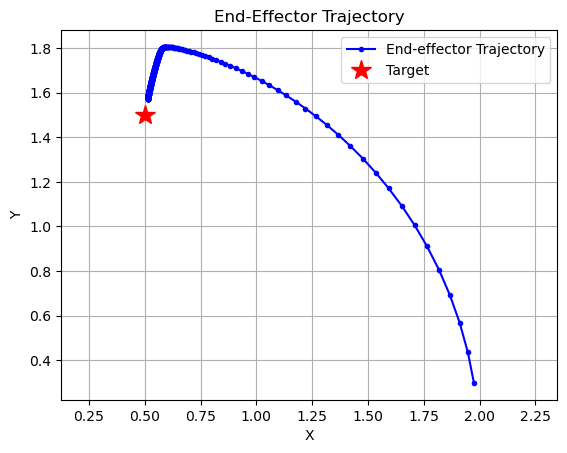

In [59]:
lr = 0.01 
theta_hist, loss_hist, ee_traj = gradient_descent(
    theta_init, goal, LENGTHS, learning_rate=lr, n_iterations=n_iterations)

plt.figure()
plt.plot(ee_traj[:,0], ee_traj[:,1], 'b.-', label='End-effector Trajectory')
plt.plot(goal[0], goal[1], 'r*', markersize=15, label='Target')
plt.title('End-Effector Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()   
plt.axis('equal')
plt.grid()
plt.show()

Prend‑on le chemin le plus direct vers la cible ?

Visuellement non. L’optimisation s’effectue dans l’espace des paramètres (les angles des articulations) et non directement dans l’espace de tâche (la position de l’effecteur). La relation entre les angles et la position de l’effecteur est non linéaire, donc une variation des angles ne se traduit pas forcément par un mouvement en ligne droite dans l’espace de tâche. Par conséquent, l’effecteur peut suivre une trajectoire courbe pour atteindre la cible.

## 2.2: SGD with Momentum

Momentum adds "inertia" to gradient descent by accumulating a velocity vector that combines the current gradient with previous gradients: $_t = \beta v_{t-1} + \nabla L(\theta_t)$
, then $\theta_{t+1} = \theta_t - \eta v_t$. This helps the optimizer build up speed in consistent directions and dampens oscillations in directions where gradients frequently change sign, allowing it to better navigate ravines and escape shallow local minima.


For this exercise, implement momentum-based gradient descent using the update rules:

$v_t = βv_{t-1} + ∇L(θ_t)$

$θ_{t+1} = θ_t - ηv_t$

<div class="alert alert-info">
Q6: Compare GD vs Momentum ($β=0.9$) on the same task ($η=0.01$, target (0.5, 1.5)). Plot both the loss curves and the end-effector trajectories side-by-side. Describe one specific, concrete difference in how the arm moves with momentum versus without.
</div>


In [90]:
def momentum(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     beta: float = 0.9,
                     n_iterations: int = 500,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    v = jnp.array([0.0])
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    v_history = np.zeros((n_iterations + 1,2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    
    # Optimization loop
    for i in range(n_iterations):
        v = beta * v + grad_fn(theta, lengths_jax, target_jax)
        
        theta = theta - learning_rate * v
        
        # Store history
        theta_history[i + 1] = np.array(theta)        
        loss_history[i + 1] = float(loss_fn(theta))        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        v_history[i + 1] = np.array(v)
    
    return theta_history, loss_history, ee_trajectory, v_history

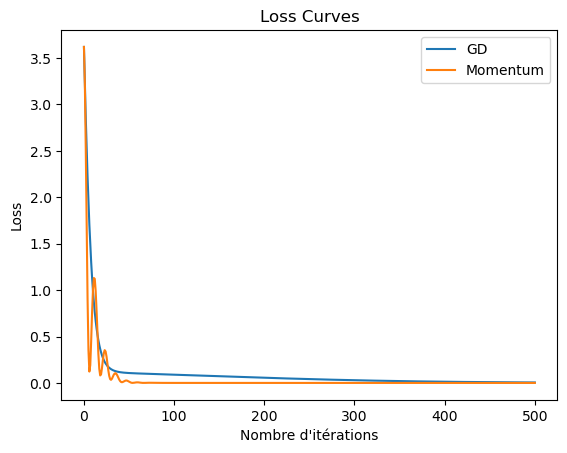

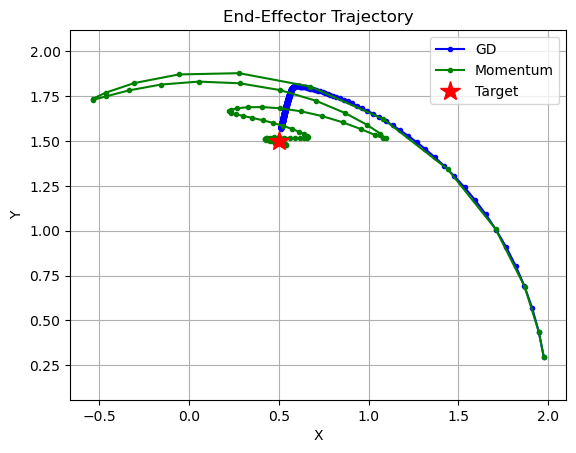

In [91]:
beta = 0.9
lr = 0.01 
goal = np.array([0.5,1.5])


# Loss curves
grad = gradient_descent(theta_init, goal, LENGTHS, learning_rate=lr, n_iterations=n_iterations)
mom = momentum(theta_init, goal, LENGTHS, learning_rate=lr, n_iterations=n_iterations)
plt.plot(grad[1], label='GD')
plt.plot(mom[1], label='Momentum')
#plt.yscale('log')
plt.title('Loss Curves')
plt.xlabel("Nombre d'itérations")
plt.ylabel('Loss')
plt.legend()
plt.show()


# End-effector Trajectory 
plt.figure()
plt.plot(grad[2][:,0], grad[2][:,1], 'b.-', label='GD')
plt.plot(mom[2][:,0], mom[2][:,1], 'g.-', label='Momentum')
plt.plot(goal[0], goal[1], 'r*', markersize=15, label='Target')
plt.title('End-Effector Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()   
plt.axis('equal')
plt.grid()
plt.show()


Sans la méthode Momentum, le bras va se rapprocher doucement de la position cible avant d'y arriver. Avec la méthode, le bras va se rapprocher plus rapidement de la position cible mais il va la dépasser et osciller autour avant d'y arriver. 

<div class="alert alert-info">
Q7: Track and plot the magnitude of the velocity vector $||v_t||$ over iterations for the momentum optimizer. What happens to this magnitude as the arm approaches the target? Explain why this behavior occurs.
</div>

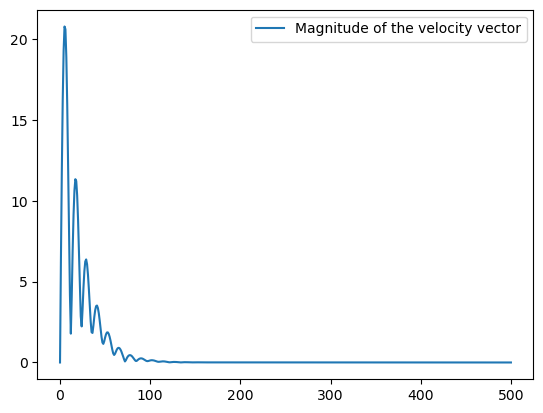

In [94]:
v_history = mom[3]
velocity_magnitude = np.linalg.norm(v_history, axis=1)

plt.plot(velocity_magnitude, label="Magnitude of the velocity vector")
plt.legend()
plt.show()

Rapidement, en se rapprochant de la cible, la valeur de la vitesse converge vers 0. 

## 2.3: Adam Optimizer

Adam (Adaptive Moment Estimation) combines ideas from momentum and adaptive learning rates by maintaining both a moving average of gradients (first moment $m_t$) and a moving average of squared gradients (second moment $v_t$).

By dividing the update by $\sqrt{v_t}$ Adam automatically adjusts the effective learning rate for each parameter based on the history of gradient magnitudes—parameters with large, consistent gradients get smaller effective steps, while parameters with small or noisy gradients get larger effective steps, making it particularly robust across different types of loss landscapes.

For this exercise, extend your Momentum SGD to include the second moment, following this update:

Update rules:
$
\begin{align}
g_t &= \nabla L(\theta_t) \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_{t+1} &= \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}
$

<div class="alert alert-info">
Q8: Start the arm at $θ = [2.5, -2.0]$ trying to reach target ($0.8, 0.8$). Compare how many iterations GD ($η=0.01$), Momentum ($β=0.9, η=0.01$), and Adam (default parameters) each need to get within distance $0.01$ of the target. Report the iteration counts and explain the ranking.
</div>

In [ ]:
def adam(theta_init: np.ndarray, 
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     beta1: float = 0.9, beta2 : float = 0.999,
                     eps : float = 1e-8,
                     n_iterations: int = 500,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    v = jnp.array([0.0])
    m = jnp.array([0.0])
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    v_history = np.zeros((n_iterations + 1,2))
    
    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    
    # Optimization loop
    for i in range(n_iterations):
        gradient = grad_fn(theta, lengths_jax, target_jax)

        m = beta1 * m + (1 - beta1) * gradient
        m_tilde = m / (1 - beta1**i)

        v = beta2 * v + (1 - beta2) * gradient**2
        v_tilde = v / (1 - beta2**i)

        theta = theta - learning_rate * m_tilde / (np.sqrt(v_tilde) + eps)
        
        # Store history
        theta_history[i + 1] = np.array(theta)        
        loss_history[i + 1] = float(loss_fn(theta))        
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        v_history[i + 1] = np.array(v)
    
    return theta_history, loss_history, ee_trajectory, v_history

In [97]:
theta_init = np.array([2.5, -2.0])
goal = np.array([0.8, 0.8])

grad = gradient_descent(theta_init, goal, LENGTHS)
mom = momentum(theta_init, goal, LENGTHS)
ad = adam(theta_init, goal, LENGTHS)

<div class="alert alert-info">
Q9: For the Adam optimizer on the same task, plot the effective per-parameter learning rate ($η_eff = η * m̂_t / (√v̂_t + ε)$) for both $θ₁$ and $θ₂$ over time. Do they receive the same effective learning rate throughout optimization? Explain why this adaptive behavior is useful.</div>

## Part 3: Gradient-Free Optimization

For this exercise, implement a basic gradient-free algorithm, specifically an evolutionary strategy. Evolution Strategies are a class of gradient-free optimization algorithms inspired by natural evolution. Unlike gradient-based methods that require computing derivatives, ES samples multiple candidate solutions (a "population") around the current solution, evaluates their fitness (objective function value), and moves toward the direction indicated by the better-performing samples. Use the following rules for your ES:

For iteration $t$, with current parameter vector $\theta_t$:
$$
\begin{align}
\epsilon_i &\sim \mathcal{N}(0, I) \quad \text{for } i = 1, \ldots, N \\
\theta_i &= \theta_t + \sigma \epsilon_i \\
F_i &= -L(\theta_i) \quad \text{(fitness = negative loss)} \\
\theta_{t+1} &= \theta_t + \alpha \frac{1}{N} \sum_{i=1}^{N} F_i \epsilon_i
\end{align}
$$

where $N$ is the population size, $\sigma$ is the exploration noise (standard deviation), $\alpha$ is the learning rate, and $\epsilon_i$ are the perturbation vectors.

<div class="alert alert-info">
    Q10: Run this ES with population sizes $P = [10, 20, 50]$. For each, report: (a) does it reach the target successfully? (b) how many iterations does it take? (c) total number of function evaluations ($P$ × iterations). What trend do you observe with increasing population size?</div>

<div class="alert alert-info">
Q11: ES doesn't use gradients, so it evaluates the loss N times per iteration while SGD evaluates it once plus one gradient computation. For a successful run of each method, count total loss function evaluations. Which is more sample-efficient? Despite this, describe one scenario where ES might still be preferred over gradient-based methods.</div>

## Part 4: Trajectory Optimization - Optimizing Sequences

So far, we've only optimized the **final configuration** of the robot arm - finding joint angles that place the end-effector at the target. However, in real robotics, we often care about the **entire motion path**. A robot might reach the target, but if it does so with jerky, energy-intensive movements, the solution isn't practical.

In this section, you'll optimize a **trajectory** - a sequence of joint angles over time - to reach the target while minimizing energy consumption and ensuring smooth motion.

### Trajectory Representation

Instead of optimizing $\theta \in \mathbb{R}^2$, we now optimize:
$$\Theta = [\theta_0, \theta_1, \ldots, \theta_T] \in \mathbb{R}^{T \times 2}$$

where $T$ is the number of timesteps (e.g., $T=20$).

### Multi-Objective Loss Function

We balance three competing objectives:

$$L_{total}(\Theta) = L_{target} + \lambda_{energy} L_{energy} + \lambda_{smooth} L_{smooth}$$

where:
- **Target reaching**: $L_{target} = \|\text{pos}(\theta_T) - \text{target}\|^2$ (only final position matters)
- **Energy cost**: $L_{energy} = \sum_{t=1}^{T} \|\theta_t - \theta_{t-1}\|^2$ (penalize large joint movements)
- **Smoothness**: $L_{smooth} = \sum_{t=2}^{T} \|(\theta_t - \theta_{t-1}) - (\theta_{t-1} - \theta_{t-2})\|^2$ (penalize acceleration/jerkiness)

The hyperparameters $\lambda_{energy}$ and $\lambda_{smooth}$ control the trade-off between reaching the target quickly versus moving efficiently and smoothly.

In [ ]:
# Trajectory Optimization Functions

def loss_trajectory(theta_sequence: jnp.ndarray, 
                   lengths: jnp.ndarray,
                   target: jnp.ndarray,
                   lambda_energy: float = 0.1,
                   lambda_smooth: float = 0.05) -> float:
    """
    Loss for trajectory optimization.
    
    Parameters:
    -----------
    theta_sequence : jnp.ndarray, shape (T, 2)
        Sequence of joint angles over T timesteps
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position
    lambda_energy : float
        Weight for energy cost
    lambda_smooth : float
        Weight for smoothness cost
    
    Returns:
    --------
    loss : float
        Total loss combining target reaching, energy, and smoothness
    """
    T = theta_sequence.shape[0]
    
    # Target reaching: only final position matters
    final_pos = forward_kinematics_jax(theta_sequence[-1], lengths)
    loss_target = jnp.sum((final_pos - target) ** 2)
    
    # Energy cost: sum of squared velocities (joint movements)
    velocities = theta_sequence[1:] - theta_sequence[:-1]  # Shape: (T-1, 2)
    loss_energy = jnp.sum(velocities ** 2)
    
    # Smoothness cost: sum of squared accelerations
    accelerations = velocities[1:] - velocities[:-1]  # Shape: (T-2, 2)
    loss_smooth = jnp.sum(accelerations ** 2)
    
    return loss_target + lambda_energy * loss_energy + lambda_smooth * loss_smooth


# Create gradient function for trajectory optimization
grad_loss_trajectory = jit(grad(loss_trajectory, argnums=0))

In [ ]:
def plot_trajectory_sequence(theta_sequence: np.ndarray,
                             lengths: np.ndarray,
                             target: np.ndarray = None,
                             title: str = "Arm Trajectory Over Time"):
    """
    Visualize the robot arm at multiple points along the trajectory.
    
    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position
    title : str
        Plot title
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    
    T = len(theta_sequence)
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    
    # Plot each arm configuration
    for t in range(0, T, max(1, T//10)):  # Show ~10 frames
        points = get_arm_points(theta_sequence[t], lengths)
        alpha = 0.3 + 0.7 * (t / T)  # Fade from transparent to opaque
        ax.plot(points[:, 0], points[:, 1], 'o-', 
               color=colors[t], alpha=alpha, linewidth=2, markersize=4)
    
    # Plot final configuration more prominently
    points_final = get_arm_points(theta_sequence[-1], lengths)
    ax.plot(points_final[:, 0], points_final[:, 1], 'o-', 
           color='red', linewidth=3, markersize=8, label='Final')
    
    # Plot end-effector trajectory
    ee_traj = np.array([forward_kinematics_numpy(theta_sequence[t], lengths) 
                        for t in range(T)])
    ax.plot(ee_traj[:, 0], ee_traj[:, 1], 'b--', 
           linewidth=2, alpha=0.5, label='End-effector path')
    
    # Plot target
    if target is not None:
        ax.plot(target[0], target[1], 'g*', markersize=20, label='Target')
    
    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()
    
    return fig, ax

In [ ]:
def analyze_trajectory_metrics(theta_sequence: np.ndarray):
    """
    Compute and print trajectory quality metrics.
    
    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    """
    velocities = np.diff(theta_sequence, axis=0)
    accelerations = np.diff(velocities, axis=0)
    
    # Compute metrics
    total_movement = np.sum(np.abs(velocities))
    max_velocity = np.max(np.linalg.norm(velocities, axis=1))
    max_acceleration = np.max(np.linalg.norm(accelerations, axis=1))
    smoothness = np.sum(accelerations ** 2)  # Lower is smoother
    
    print("Trajectory Metrics:")
    print(f"  Total joint movement: {total_movement:.4f} radians")
    print(f"  Max velocity: {max_velocity:.4f} rad/timestep")
    print(f"  Max acceleration: {max_acceleration:.4f} rad/timestep²")
    print(f"  Smoothness cost: {smoothness:.4f} (lower is better)")

In [ ]:
# Test trajectory optimization with gradient descent
def gradient_descent_trajectory(theta_init: np.ndarray,
                               target: np.ndarray,
                               lengths: np.ndarray,
                               T: int = 20,
                               learning_rate: float = 0.01,
                               n_iterations: int = 1000,
                               lambda_energy: float = 0.1,
                               lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    loss_history = []
    
    for iteration in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                   lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                       lambda_energy, lambda_smooth)
        
        # Update trajectory
        theta_sequence = theta_sequence - learning_rate * gradient
        
        loss_history.append(float(loss_val))
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In [ ]:
# Example usage
print("="*60)
print("Testing Trajectory Optimization")
print("="*60)

theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print(f"\nOptimizing trajectory with T={T} timesteps")
print(f"Initial configuration: {theta_init}")
print(f"Target position: {target}\n")

theta_traj, loss_hist = gradient_descent_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.01, n_iterations=1000,
    lambda_energy=0.1, lambda_smooth=0.05
)

In [ ]:
# Visualize results
plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
plt.show()

plot_trajectory_sequence(theta_traj, LENGTHS, target)
plt.show()

analyze_trajectory_metrics(theta_traj)

<div class="alert alert-info">
Q12: Run trajectory optimization with three different energy weights: $\lambda_{energy} = [0.01, 0.1, 1.0]$ (keep $\lambda_{smooth}=0.05$ fixed). For each, visualize the resulting trajectory and report the total joint movement (sum of velocity magnitudes). How does increasing the energy penalty affect the motion? Does the arm still reach the target?
</div>

<div class="alert alert-info">
Q13: Compare trajectory optimization using SGD with Momentum vs Adam. Use $T=20$, $\lambda_{energy}=0.1$, $\lambda_{smooth}=0.05$. Which converges faster? Plot both trajectories side-by-side. Do they find qualitatively different solutions (different motion strategies)?
</div>

<div class="alert alert-info">
Q14: The trajectory optimization problem has $T \times 2$ parameters (40 parameters for $T=20$). This is similar to optimizing a small neural network. Based on your experiments, which optimizer (GD, Momentum, Adam) would you recommend for optimizing trajectories? How might your answer change if $T=100$ (200 parameters)?
</div>

<div class="alert alert-info">
Q15: Gradient-free methods can also optimize trajectories! However, with $T \times 2$ parameters, the search space becomes much larger. Implement ES for trajectory optimization. Use a smaller population size initially (N=10) and $T=10$ timesteps to keep computation manageable. Compare sample efficiency (total function evaluations) with Adam. When might ES be preferred despite being less sample-efficient?
</div>